In [1]:
%pip install davos
import davos

%conda install pytables

davos.config.suppress_stdout = True

Note: you may need to restart the kernel to use updated packages.
Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 22.9.0
  latest version: 23.11.0

Please update conda by running

    $ conda update -n base -c defaults conda



# All requested packages already installed.

Retrieving notices: ...working... done

Note: you may need to restart the kernel to use updated packages.


In [2]:
smuggle nltools as nlt            # pip: nltools==0.4.7

smuggle nilearn as nl             # pip: nilearn==0.10.0
smuggle nibabel as nib            # pip: nibabel==5.0.1

smuggle datawrangler as dw        # pip: pydata-wrangler==0.2.2
from statsmodels.stats.multitest smuggle multipletests        # pip: statsmodels==0.14.0

smuggle numpy as np               # pip: numpy==1.24.2
smuggle matplotlib.pyplot as plt  # pip: matplotlib==3.7.0
from matplotlib.colors smuggle ListedColormap

smuggle pandas as pd              # pip: pandas==1.5.3
smuggle seaborn as sns            # pip: seaborn==0.12.2
from skimage smuggle transform    # pip: scikit-image==0.20.0

from sklearn.decomposition smuggle IncrementalPCA as PCA      # pip: scikit-learn==1.2.1
from scipy.spatial.distance smuggle cdist                     # pip: scipy==1.10.1
from scipy.stats import spearmanr
from scipy.io smuggle loadmat
from tqdm smuggle tqdm            # pip: tqdm==4.64.1

smuggle requests                  # pip: requests==2.28.2

from datetime import datetime as dt
import os
import shutil
import pickle
import warnings
from glob import glob as lsdir

from helpers import nii2cmu, conditions, condition_colors, figdir, basedir, datadir, scratch_dir, group_pca, cross_validation, ridge_plot, get_data, info_and_compressibility, rbf, pstring

Load in network labels

In [3]:
nii_fname = os.path.join(datadir, 'networks', 'Schaefer2018_1000Parcels_7Networks_order_FSLMNI152_2mm.nii.gz')

In [4]:
key = os.path.join(datadir, 'networks', os.path.join(datadir, 'networks', 'Schaefer2018_1000Parcels_7Networks_order.txt'))
key = pd.read_csv(key, sep='\t', header=None, names=['id', 'name', 'x', 'y', 'z', 't']).drop('t', axis=1)
key['study'] = key['name'].apply(lambda x: x.split('_')[0])
key['hemisphere'] = key['name'].apply(lambda x: x.split('_')[1][0])
key['network'] = key['name'].apply(lambda x: x.split('_')[2])
key.drop('name', axis=1, inplace=True)

lookup_table = {
    'Vis': 'Visual',
    'SomMot': 'Somatomotor',
    'DorsAttn': 'Dorsal attention',
    'SalVentAttn': 'Ventral attention',
    'Limbic': 'Limbic',
    'Cont': 'Frontoparietal',
    'Default': 'Default mode'
}

network_colors = {
    'Visual': '#D7DF23',
    'Somatomotor': '#39B54A',
    'Dorsal attention': '#00A79D',
    'Ventral attention': '#27AAE1',
    'Limbic': '#1C75BC',
    'Frontoparietal': '#92278F',
    'Default mode': '#EE2A7B'
}

colors = ['#888888']
colors.extend([v for k, v in network_colors.items()])
network_cmap = ListedColormap(colors, N=len(colors)*2, name='networks')  # why do I need to double the number of colors?

network_codes = {k: i + 1 for i, k in enumerate(lookup_table.values())}

key['network'] = key['network'].apply(lambda x: lookup_table[x])
key['code'] = key['network'].apply(lambda x: network_codes[x])
key.set_index('id', inplace=True)
key.loc[0, 'code'] = 0  # append a background (non-network) code
key

,x,y,z,study,hemisphere,network,code
id,,,,,,,
1,120.0,14.0,127.0,7Networks,L,Visual,1.0
2,120.0,14.0,128.0,7Networks,L,Visual,1.0
3,120.0,14.0,129.0,7Networks,L,Visual,1.0
4,120.0,14.0,130.0,7Networks,L,Visual,1.0
5,120.0,14.0,131.0,7Networks,L,Visual,1.0
...,...,...,...,...,...,...,...
997,208.0,65.0,82.0,7Networks,R,Default mode,7.0
998,208.0,65.0,83.0,7Networks,R,Default mode,7.0
999,235.0,149.0,37.0,7Networks,R,Frontoparietal,6.0


# Figure 4A

Plot the networks

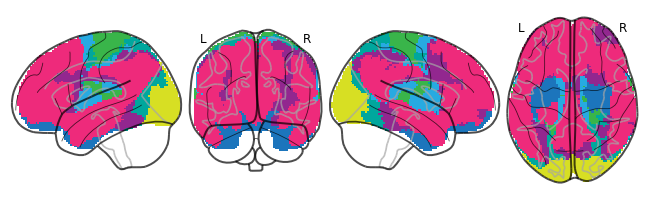

In [5]:
nx = nlt.Brain_Data(nii_fname)
nx.data = np.array([key.loc[i, 'code'] for i in nx.data]).astype(float)
networks = nx.to_nifti()

fname = os.path.join(figdir, 'networks.pdf')
nl.plotting.plot_glass_brain(networks, cmap=network_cmap, display_mode='lyrz', output_file=fname)

# also display figure here
nl.plotting.plot_glass_brain(networks, cmap=network_cmap, display_mode='lyrz')

Load in HTFA nodes

In [6]:
url = 'https://www.dropbox.com/s/29a48lv3j5ybcvw/pieman2_htfa.pkl?dl=1'

fname = os.path.join(datadir, 'pieman2_htfa.pkl')
if not os.path.exists(fname):
    with open(fname, 'wb') as f:
        data = requests.get(url).content
        f.write(data)

with open(fname, 'rb') as f:
    data = pickle.load(open(fname, 'rb'))

centers = data['centers']
widths = data['widths']

Label each node with its highest-weighted network, according to the parcellation file

In [7]:
# load network parcellations in CMU format
networks_cmu = nii2cmu(nii_fname)

# covert voxel values in the reference image to network codes
networks_cmu['Y'] = np.atleast_2d(np.array([key.loc[i, 'code'] for i in networks_cmu['Y']]).astype(float))

In [8]:
def node_labels(centers, widths, networks_cmu):
    labels = []
    for c, w in zip(centers, widths):
        r = rbf(networks_cmu['R'], c, w)

        label_weights = [sum(r[networks_cmu['Y'].ravel() == i]) for i in range(1, len(network_codes) + 1)]
        labels.append(np.argmax(label_weights) + 1)
    
    return pd.DataFrame({'code': labels, 'Network': [list(lookup_table.values())[i - 1] for i in labels]})

In [9]:
node_codes = node_labels(centers, widths, networks_cmu)
node_codes

,code,Network
0,4,Ventral attention
1,3,Dorsal attention
2,1,Visual
3,6,Frontoparietal
4,4,Ventral attention
...,...,...
695,2,Somatomotor
696,4,Ventral attention
697,4,Ventral attention
698,4,Ventral attention


# Figure 4B

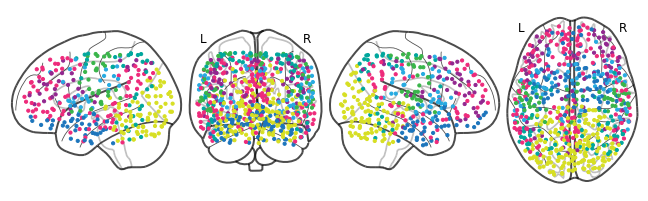

In [10]:
nl.plotting.plot_connectome(np.eye(centers.shape[0]), centers, node_size=10, node_color=[colors[i] for i in node_codes['code']], display_mode='lyrz', output_file=os.path.join(figdir, 'htfa.pdf'))
nl.plotting.plot_connectome(np.eye(centers.shape[0]), centers, node_size=10, node_color=[colors[i] for i in node_codes['code']], display_mode='lyrz')

In [11]:
network_counts = pd.DataFrame(node_codes.value_counts()).rename(columns={0: 'Number of nodes'}).sort_index()
network_counts

,,Number of nodes
code,Network,
1,Visual,183
2,Somatomotor,64
3,Dorsal attention,68
4,Ventral attention,72
5,Limbic,88
6,Frontoparietal,77
7,Default mode,148


# Figure 4C

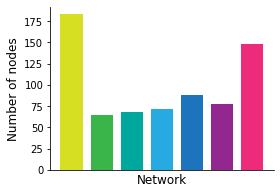

In [12]:
fig = plt.figure(figsize=(4, 3))
ax = plt.gca()

sns.histplot(data=node_codes, x='code', color='k', shrink=0.75, hue='code', hue_order=range(1, 8), palette=colors[1:], alpha=1.0, legend=False, ax=ax, discrete=True, edgecolor=None)
ax.set_xlabel('Network', fontsize=12)
ax.set_ylabel('Number of nodes', fontsize=12)

ax.set_xticks([])
ax.spines[['right', 'top']].set_visible(False)

fig.savefig(os.path.join(figdir, 'htfa_node_counts.pdf'), bbox_inches='tight')


# Do PCA on a per-network basis

First fetch/load the data...

In [13]:
data = get_data()

For each network, load (computing and saving as needed) the reduced versions of the data using $k \in \{3, 4, 5, ..., m\}$ components (where $m$ is the number of nodes in the given network)

In [14]:
reduced_data = {}

for x in network_counts.index.values:
    next_name = x[1]
    reduced_data[next_name] = {}
    
    for c in conditions:
        reduced_data[next_name][c] = {}

for c in conditions:
    reduced_data[c] = {}
    for x in network_counts.index.values:
        next_name = x[1]
        reduced_data[c][next_name] = {}

        max_components = network_counts.loc[x]['Number of nodes']

        inds = node_codes[node_codes['Network'] == next_name].index.values
                
        for n in tqdm(range(3, max_components + 1)):
            fname = os.path.join(scratch_dir, f'pca_{next_name}_{c}_{n}.pkl')
            reduced_data[next_name][c][n], _ = group_pca([d[inds] for d in data['weights'][c]], n_components=n, fname=fname)
    
    data['weights'].pop(c)


100%|██████████| 146/146 [00:01<00:00, 135.55it/s]


Run the cross-validated decoding analysis for each network/condition/number of components

TODO: here's where I can implement a permutation test using randomized feature selection across networks:
  - instead of selecting per-network features, I could write a function to randomly reassign features across the different networks (using the existing dimensionality reductions)
  - then i'd want to re-run the cross-validation decoding analysis for each of n_xval_iters iterations (shuffling the data each time)
  - then i could combine those shuffled iterations into a single set of results and re-create the "ic_results" dataframe, but as a shuffled version
  - remaking 4E and 4F using those shuffled datasets should show us whether the results depend on the numbers of nodes in each network

Another thought: I could potentially do this *without* using reduced data (just on the raw data)...

In [15]:
n_iter = 100

decoding_results = {}
for x in network_counts.index.values:
    next_name = x[1]
    decoding_results[next_name] = {}

    max_components = network_counts.loc[x]['Number of nodes']

    for c in conditions:
        # full time range
        fname = os.path.join(scratch_dir, f'decoding_results_{n_iter}_{next_name}_{c}.pkl')
        decoding_results[next_name][c] = cross_validation(reduced_data[next_name][c], n_iter=n_iter, fname=fname, max_components=max_components)

Look at informativeness and compressibility by network/condition

In [16]:
x = {nc[1]: info_and_compressibility(decoding_results[nc[1]], target=0.05) for nc in network_counts.index.values}
ic_results = []

for k, v in x.items():
    next_df = v
    next_df['Network'] = k
    ic_results.append(next_df)

ic_results = pd.concat(ic_results)
ic_results['Condition'] = ic_results['Condition'].apply(lambda x: x.capitalize())
ic_results['Proportion of components'] = ic_results.apply(lambda x: x['Number of components'] / int(network_counts.reset_index().query(f'Network == "{x["Network"]}"')['Number of nodes']), axis=1)

In [17]:
ic_results

,Number of components,Relative decoding accuracy,Condition,Iteration,Network,Proportion of components
0,15,0.073333,Intact,0,Visual,0.081967
1,74,0.076667,Intact,1,Visual,0.404372
2,9,0.090000,Intact,2,Visual,0.049180
3,20,0.071667,Intact,3,Visual,0.109290
4,18,0.078333,Intact,4,Visual,0.098361
...,...,...,...,...,...,...
395,21,0.007500,Rest,95,Default mode,0.141892
396,43,0.008750,Rest,96,Default mode,0.290541
397,54,0.010000,Rest,97,Default mode,0.364865
398,11,0.013750,Rest,98,Default mode,0.074324


# Figure 4D

<Figure size 864x216 with 0 Axes>

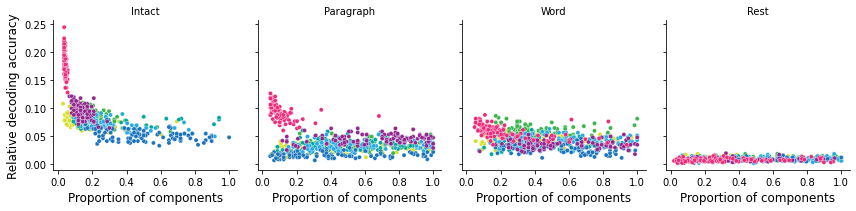

In [18]:
fig = plt.figure(figsize=(12, 3))

g = sns.FacetGrid(ic_results, col='Condition', hue='Network', palette=list(network_colors.values()))
g.map(sns.scatterplot, 'Proportion of components', 'Relative decoding accuracy', size=2)

g.set_titles(col_template='{col_name}', fontsize=12)
g.set_axis_labels('Proportion of components', 'Relative decoding accuracy', fontsize=12)

fig = plt.gcf()
fig.savefig(os.path.join(figdir, 'decoding_and_compressibility_scatterplots_by_network.pdf'), bbox_inches='tight')


# Figure 4E

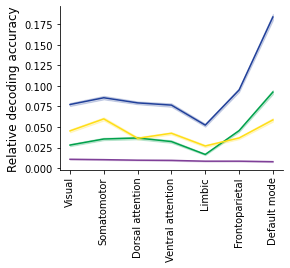

In [25]:
fig = plt.figure(figsize=(4, 3))
sns.lineplot(data=ic_results, x='Network', y='Relative decoding accuracy', hue='Condition', palette=[condition_colors[c] for c in conditions], legend=False)

ax = plt.gca()
ax.set_xlabel('')
plt.xticks(rotation=90)
ax.set_ylabel('Relative decoding accuracy', fontsize=12);
sns.despine(right=True, top=True)

fig.savefig(os.path.join(figdir, 'decoding_by_network.pdf'), bbox_inches='tight')

## Stats associated with Figs 4D and E

Claim: "Moving from lower-order networks to higher-order networks, we found that decoding accuracy tended to increase."  To test this, compute the rank correlation between ranked order and decoding accuracy, separately for each condition.

Note: we'll use the [Benjamini/Hochberg procedure](https://www.statsmodels.org/dev/generated/statsmodels.stats.multitest.multipletests.html) to correct for multiple comparisons, as in the [decoding_and_compression](../decoding_and_compression.ipynb) notebook

In [21]:
# add network "order"
network_order = {n: i for i, n in enumerate(network_colors.keys())}
ic_results['Network order'] = ic_results['Network'].apply(lambda x: network_order[x])
ic_results

,Number of components,Relative decoding accuracy,Condition,Iteration,Network,Proportion of components,Network order
0,15,0.073333,Intact,0,Visual,0.081967,0
1,74,0.076667,Intact,1,Visual,0.404372,0
2,9,0.090000,Intact,2,Visual,0.049180,0
3,20,0.071667,Intact,3,Visual,0.109290,0
4,18,0.078333,Intact,4,Visual,0.098361,0
...,...,...,...,...,...,...,...
395,21,0.007500,Rest,95,Default mode,0.141892,6
396,43,0.008750,Rest,96,Default mode,0.290541,6
397,54,0.010000,Rest,97,Default mode,0.364865,6
398,11,0.013750,Rest,98,Default mode,0.074324,6


In [22]:
correlations = []

networks = list(network_colors.keys())

for cond in conditions:
    next_df = ic_results.query(f'Condition == "{cond.capitalize()}"')
    if len(next_df) > 2 and len(next_df['Network'].unique()) > 1:
        results = spearmanr(next_df['Network order'], next_df['Relative decoding accuracy'])
        correlations.append(pd.DataFrame.from_records([{'Condition': cond.capitalize(), 'rho': results[0], 'p': results[1]}]))

correlations = pd.concat(correlations, ignore_index=True, axis=0)
correlations['p (corrected)'] = multipletests(correlations['p'], method='fdr_bh')[1]

# print correlations for easy copy-pasting into manuscript
for i, row in correlations.iterrows():
    print(f'{row["Condition"]}: $\\rho = {row["rho"]:.3f}, {pstring(row["p (corrected)"])}$')

Intact: $\rho = 0.362, p < 0.001$
Paragraph: $\rho = 0.441, p < 0.001$
Word: $\rho = -0.102, p = 0.007$
Rest: $\rho = -0.354, p < 0.001$


In [23]:
# display table
correlations

,Condition,rho,p,p (corrected)
0,Intact,0.361531,4.865413e-23,9.730826e-23
1,Paragraph,0.441369,9.809940e-35,3.923976e-34
2,Word,-0.102064,6.880176e-03,6.880176e-03
3,Rest,-0.354434,3.792542e-22,5.056722e-22


# Figure 4F

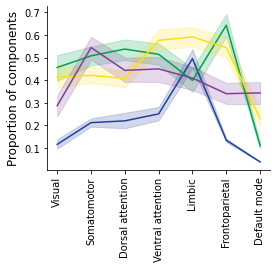

In [26]:
fig = plt.figure(figsize=(4, 3))
sns.lineplot(data=ic_results, x='Network', y='Proportion of components', hue='Condition', palette=[condition_colors[c] for c in conditions], legend=False)

ax = plt.gca()
ax.set_xlabel('')
plt.xticks(rotation=90)
ax.set_ylabel('Proportion of components', fontsize=12);
sns.despine(right=True, top=True)

fig.savefig(os.path.join(figdir, 'compressibility_by_network.pdf'), bbox_inches='tight')